## Test of BERT in TensorFlow - Keras

Code based on https://huggingface.co/transformers/quickstart.html

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from transformers import BertTokenizer, TFBertModel

In [4]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenizer.encode(text, add_special_tokens=False)

[101,
 2040,
 2001,
 3958,
 27227,
 1029,
 102,
 3958,
 27227,
 2001,
 1037,
 13997,
 11510,
 102]

In [115]:
#tokenizer.prepare_for_model(tokenizer.encode(text, add_special_tokens=False))

{'input_ids': [101,
  101,
  2040,
  2001,
  3958,
  27227,
  1029,
  102,
  3958,
  27227,
  2001,
  1037,
  13997,
  11510,
  102,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [6]:
# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
tokenized_text

['[CLS]',
 'who',
 'was',
 'jim',
 'henson',
 '?',
 '[SEP]',
 'jim',
 'henson',
 'was',
 'a',
 'puppet',
 '##eer',
 '[SEP]']

In [7]:
# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
indexed_tokens

[101,
 2040,
 2001,
 3958,
 27227,
 1029,
 102,
 3958,
 27227,
 2001,
 1037,
 13997,
 11510,
 102]

# IMDB data preparation
From https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

In [8]:
import os
import re
import pandas as pd
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

In [9]:
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,De Sica is becoming one of my favorite directo...,7,1
1,This adaptation positively butchers a classic ...,1,0
2,I was pretty young when this came out in the U...,10,1
3,I occasionally see some of this show because m...,3,0
4,For Urban Cowboy John Travolta plays one of th...,7,1


In [10]:
import numpy as np
# Create datasets (Only take up to max_seq_length words for memory)
max_seq_length = 500
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
#train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
#test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()


In [11]:
train_text[:3]

['De Sica is becoming one of my favorite directors, but this one was a hit-and-miss for me. A grinning idiot youth becomes the leader of a community of illegal settlers in a deserted area outside Milano. It is a detailed and sparkling story of the innocent poor masses, complete with evil capitalists and trigger-happy police forces, but slowly it evolves into a magic fantasy tale, as the boy wonder Toto develops unlimited superhero powers. I had it up to here with the ever-smiling Toto after 10 minutes, and when the magic took over, I was left in the dust. There were so many wonderfully orchestrated shots, so many good characters among the settlers, that I kept thinking it was a waste the movie wasn\'t more serious with its material. The coupling of neorealism and fantasy comes out more as an experiment of the "look-what-we-can-also-do-mum" sort than as a fully developed piece of work/art.',
 'This adaptation positively butchers a classic which is beloved for its subtlety. Timothy Dalto

In [12]:
train_label[:3]

[1, 0, 1]

In [13]:
from multiprocessing import Pool
from functools import partial
def text_to_indices(data, limit=500):
    "Convert the text to indices and pad-truncate to the maximum number of words"
    with Pool() as pool:
        return pool.map(partial(tokenizer.encode,
                                      add_special_tokens=True, max_length=limit, pad_to_max_length=True),
                         data)

In [14]:
text_to_indices(["this is sentence 1", "this is sentence 2"], limit=10)

[[101, 2023, 2003, 6251, 1015, 102, 0, 0, 0, 0],
 [101, 2023, 2003, 6251, 1016, 102, 0, 0, 0, 0]]

In [51]:
print("Obtaining indices of train set")
train_indices = text_to_indices(train_text)
print("Obtaining indices of test set")
test_indices = text_to_indices(test_text)

Obtaining indices of train set
Obtaining indices of test set


# Results with BERT

In [29]:
# Load pre-trained model (weights)
bert = TFBertModel.from_pretrained('bert-base-uncased', trainable=False)

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D

In [44]:
# From https://huggingface.co/transformers/_modules/transformers/modeling_tf_bert.html#TFBertModel
#inputs = tf.constant(indexed_tokens)[None, :] # Batch  size 1
inputs = Input(shape=(500,), dtype=tf.int32)
last_hidden_states = bert(inputs)[0]  # The last hidden-state is the first element of the output tuple
average_pooling = GlobalAveragePooling1D()(last_hidden_states) # Average pooling of last hidden states as recommended
outputs = Dense(1, activation=tf.nn.sigmoid)(average_pooling)
bert_model = Model(inputs, outputs)
bert_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 500, 768), (None, 109482240 
_________________________________________________________________
global_average_pooling1d_1 ( (None, 768)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 769       
Total params: 109,483,009
Trainable params: 769
Non-trainable params: 109,482,240
_________________________________________________________________


In [47]:
bert_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [87]:
history = bert_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
 6272/20000 [========>.....................] - ETA: 5:09 - loss: 0.5593 - acc: 0.7677

# Results with Average baseline

In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D

In [80]:
max_features = tokenizer.vocab_size
embeddings_size = 32
inputs = Input(shape=(500,), dtype=tf.int32)
embedding = Embedding(max_features, embeddings_size)(inputs)
avg = GlobalAveragePooling1D()(embedding)
outputs = Dense(1, activation=tf.nn.sigmoid)(avg)
avg_model = Model(inputs, outputs)
avg_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 500, 32)           976704    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 976,737
Trainable params: 976,737
Non-trainable params: 0
_________________________________________________________________


In [81]:
avg_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [85]:
history = avg_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 109us/sample - loss: 0.2386 - acc: 0.9220 - val_loss: 0.2937 - val_acc: 0.8948
Epoch 2/20
20000/20000 [==============================] - 2s 110us/sample - loss: 0.2284 - acc: 0.9255 - val_loss: 0.2899 - val_acc: 0.8972
Epoch 3/20
20000/20000 [==============================] - 2s 108us/sample - loss: 0.2193 - acc: 0.9288 - val_loss: 0.2839 - val_acc: 0.8978
Epoch 4/20
20000/20000 [==============================] - 2s 108us/sample - loss: 0.2101 - acc: 0.9332 - val_loss: 0.2825 - val_acc: 0.8964
Epoch 5/20
20000/20000 [==============================] - 2s 108us/sample - loss: 0.2020 - acc: 0.9357 - val_loss: 0.2783 - val_acc: 0.8986
Epoch 6/20
20000/20000 [==============================] - 2s 109us/sample - loss: 0.1942 - acc: 0.9390 - val_loss: 0.2743 - val_acc: 0.9010
Epoch 7/20
20000/20000 [==============================] - 2s 110us/sample - loss: 0.1866 - acc: 0.9421 - val_lo

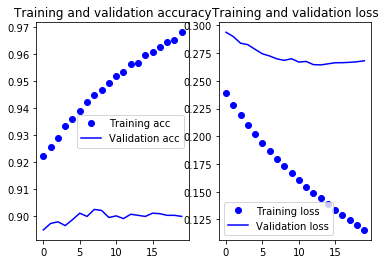

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Results with LSTM baseline

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM

In [73]:
max_features = tokenizer.vocab_size
embeddings_size = 32
inputs = Input(shape=(500,), dtype=tf.int32)
embedding = Embedding(max_features, embeddings_size)(inputs)
lstm = LSTM(embeddings_size, dropout=0.2)(embedding)
outputs = Dense(1, activation=tf.nn.sigmoid)(lstm)
lstm_model = Model(inputs, outputs)
lstm_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 500, 32)           976704    
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 985,057
Trainable params: 985,057
Non-trainable params: 0
_________________________________________________________________


In [74]:
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [76]:
history = lstm_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 228us/sample - loss: 0.5878 - acc: 0.6486 - val_loss: 0.7062 - val_acc: 0.5234
Epoch 2/10
20000/20000 [==============================] - 5s 227us/sample - loss: 0.5970 - acc: 0.5777 - val_loss: 0.7226 - val_acc: 0.5260
Epoch 3/10
20000/20000 [==============================] - 5s 226us/sample - loss: 0.5865 - acc: 0.5838 - val_loss: 0.7317 - val_acc: 0.5284
Epoch 4/10
20000/20000 [==============================] - 5s 227us/sample - loss: 0.5722 - acc: 0.6180 - val_loss: 0.7003 - val_acc: 0.6314
Epoch 5/10
20000/20000 [==============================] - 5s 229us/sample - loss: 0.4831 - acc: 0.7793 - val_loss: 0.6230 - val_acc: 0.7220
Epoch 6/10
20000/20000 [==============================] - 5s 228us/sample - loss: 0.4714 - acc: 0.7901 - val_loss: 0.6402 - val_acc: 0.7424
Epoch 7/10
20000/20000 [==============================] - 5s 229us/sample - loss: 0.5017 - acc: 0.7710 - val_lo

In [60]:
len(train_indices)

25000

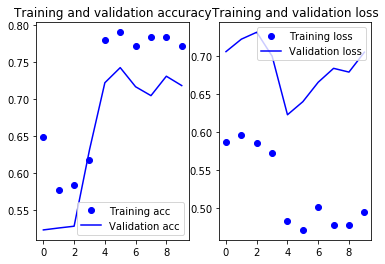

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()